In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
import sys
import os
sys.path.append(os.path.abspath('src'))
from utils import compare_metrics, plot_forecasts

import warnings
warnings.filterwarnings("ignore")


# Data Retrieval

### Load Data

In [5]:
# The target variable is loaded in two versions:
df_Y_complete = pd.read_csv('data/raw/complete_target.csv', index_col=0, parse_dates=True)
df_Y_target = pd.read_csv('data/raw/target.csv', index_col=0, parse_dates=True) # Short version

# Exogenous Variables
df_X_ppi = pd.read_csv('data/raw/ppi_growth.csv', index_col=0, parse_dates=True)
df_X_unemp = pd.read_csv('data/raw/Unemployment.csv', index_col=0, parse_dates=True)
df_X_oil = pd.read_csv('data/raw/brent.csv', index_col=0, parse_dates=True)
df_X_cli = pd.read_csv('data/raw/cli.csv', index_col=0, parse_dates=True)

# Rename columns for clarity and consistency
df_Y_complete.columns = ['Y_IPI_Level']
df_Y_target.columns = ['Y_IPI_Level'] # Note: 'target' is the same series as the tail of 'complete_target'
df_X_ppi.columns = ['X_PPI_Growth']
df_X_unemp.columns = ['X_UNEMP_Level']
df_X_oil.columns = ['X_OIL_Level']
df_X_cli.columns = ['X_CLI_Level']

### Visualization of target data (Both complete and limited for exogenous variables)

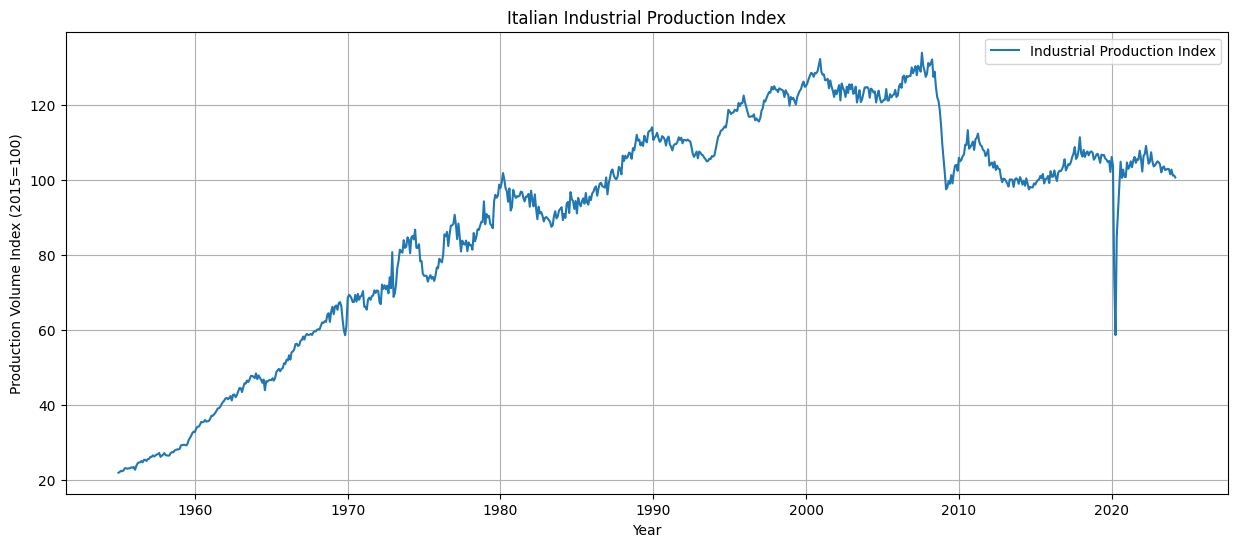

In [6]:
# Visualize initial time series
plt.figure(figsize=(15,6))
plt.plot(df_Y_complete.index, df_Y_complete['Y_IPI_Level'], label='Industrial Production Index')
plt.title('Italian Industrial Production Index')
plt.xlabel('Year')
plt.ylabel('Production Volume Index (2015=100)')
plt.legend()
plt.grid(True)
plt.show()

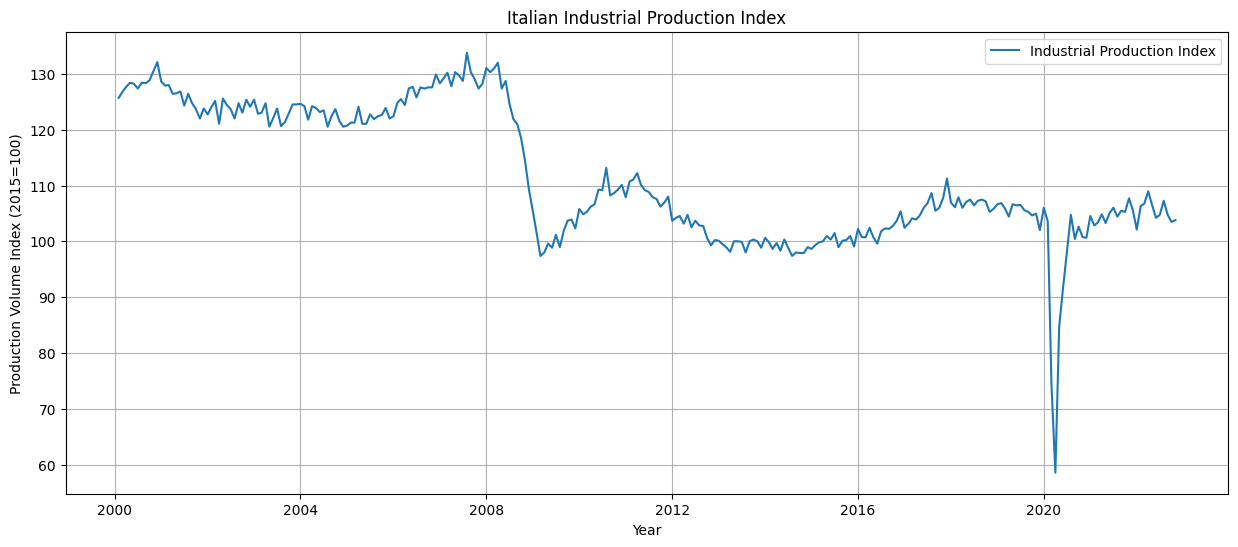

In [7]:
# Visualize initial time series
plt.figure(figsize=(15,6))
plt.plot(df_Y_target.index, df_Y_target['Y_IPI_Level'], label='Industrial Production Index')
plt.title('Italian Industrial Production Index')
plt.xlabel('Year')
plt.ylabel('Production Volume Index (2015=100)')
plt.legend()
plt.grid(True)
plt.show()

we notice that limiting the dataset for adherence with the exogenous variable we don't have the clear increasing trend in the data and we have to tackle the difficulties emerging from the 2008 and 2020 crisis

In [8]:
# All data is merged to the latest start date (Jan 2000 constraint)
df_aligned = df_Y_target.join([df_X_ppi, df_X_unemp, df_X_oil, df_X_cli], how='inner').dropna()

df_aligned

,Y_IPI_Level,X_PPI_Growth,X_UNEMP_Level,X_OIL_Level,X_CLI_Level
observation_date,,,,,
2000-02-01,125.7063,0.417944,9.3,28.030476,101.543688
2000-03-01,126.7591,0.638520,9.2,27.494348,101.637662
2000-04-01,127.7066,-0.041605,9.1,23.153500,101.705034
2000-05-01,128.4436,0.595479,9.0,27.805217,101.743914
2000-06-01,128.2330,0.416341,9.0,30.483182,101.755679
...,...,...,...,...,...
2022-07-01,104.7552,2.594224,6.7,105.252857,99.208340
2022-08-01,107.2820,1.696703,6.7,97.643043,98.976413
2022-09-01,104.7552,1.671641,6.7,90.608182,98.782849


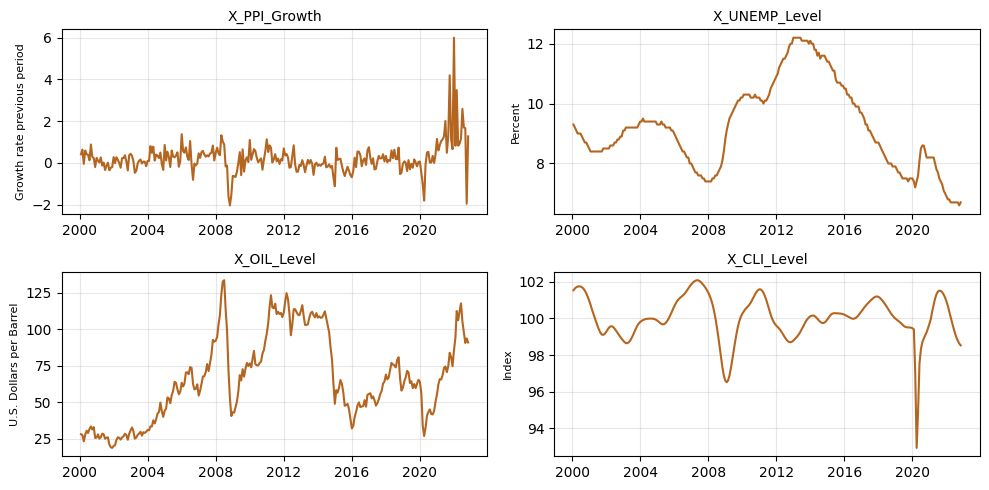

In [9]:
# 1. Identify exogenous columns
x_columns = [col for col in df_aligned.columns if col.startswith('X')]

# 2. Create a 2x2 Grid of Subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 5))
axes = axes.flatten()  # Flatten the 2D grid into a 1D list for easy iteration

# 3. Loop through columns and plot on specific axes
for i, col in enumerate(x_columns):
    # Safety check in case you have fewer/more columns
    if i < len(axes):
        ax = axes[i]
        
        # Plot data
        ax.plot(df_aligned.index, df_aligned[col], color="#b4651f", linewidth=1.5)
        
        # Styling
        ax.set_title(col, fontsize=10)
        ax.grid(True, alpha=0.3)
    
    if "OIL" in col:
        ax.set_ylabel('U.S. Dollars per Barrel', fontsize = 8)
    elif "PPI" in col:
        ax.set_ylabel('Growth rate previous period', fontsize = 8)
    elif "UNEMP" in col:
        ax.set_ylabel('Percent', fontsize = 8)
    else: 
        ax.set_ylabel('Index', fontsize = 8)

# 4. Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

Notice:

- UNEMP, CLI and Target variable (IPI) have all already been seasonally adjusted

# Stationarity Check and transformation

### Test stationarity before differencing

In [10]:
# --- Prepare Log-Level/Level Series for Testing ---
series_to_test = {
    'Y_IPI (Log-Level)': np.log(df_aligned['Y_IPI_Level']),
    'X_PPI': df_aligned['X_PPI_Growth'],
    'X_OIL (Log-Level)': np.log(df_aligned['X_OIL_Level']),
    'X_UNEMP (Level)': df_aligned['X_UNEMP_Level'],
    'X_CLI (Log-Level)': np.log(df_aligned['X_CLI_Level']),
}


# Function for ADF test (re-defined here for integration)
def run_adf_test(series, name):
    print(f"--- ADF Test for {name} ---")

    result = adfuller(series, regression='c')
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    
    cv_5_percent = result[4]['5%']
    print(f'Critical Value (5%): {cv_5_percent:.4f}')

    # Check for I(1) status
    if result[0] < cv_5_percent:
        print(f"Conclusion: Reject H0. Series is **Stationary** (Justifies stopping at I(0)).")
    else:
        print(f"Conclusion: Fail to Reject H0. Series is **Non-Stationary (I(1))** (Justifies Differencing).")
    print("-" * 40)


# --- Execute Diagnostics for all 5 Series ---
print("\n" + "=" * 60)
print("PRE-TRANSFORMATION DIAGNOSTIC (Target and Exogenous Variables)")
print("=" * 60)

for name, series in series_to_test.items():
    run_adf_test(series.dropna(), name)

print("=" * 60)


PRE-TRANSFORMATION DIAGNOSTIC (Target and Exogenous Variables)
--- ADF Test for Y_IPI (Log-Level) ---
ADF Statistic: -2.0751
p-value: 0.2546
Critical Value (5%): -2.8723
Conclusion: Fail to Reject H0. Series is **Non-Stationary (I(1))** (Justifies Differencing).
----------------------------------------
--- ADF Test for X_PPI ---
ADF Statistic: -3.1244
p-value: 0.0248
Critical Value (5%): -2.8726
Conclusion: Reject H0. Series is **Stationary** (Justifies stopping at I(0)).
----------------------------------------
--- ADF Test for X_OIL (Log-Level) ---
ADF Statistic: -2.3585
p-value: 0.1538
Critical Value (5%): -2.8722
Conclusion: Fail to Reject H0. Series is **Non-Stationary (I(1))** (Justifies Differencing).
----------------------------------------
--- ADF Test for X_UNEMP (Level) ---
ADF Statistic: -1.6563
p-value: 0.4537
Critical Value (5%): -2.8726
Conclusion: Fail to Reject H0. Series is **Non-Stationary (I(1))** (Justifies Differencing).
----------------------------------------
-

Diagnostic testing reveals that the dataset contains both stationary and non-stationary variables. 

The ADF test confirms that the Producer Price Index ($X_{PPI}$) and Composite Leading Indicator ($X_{CLI}$) are already stationary and safe to model ($p < 0.05$).

However, the Industrial Production Index ($Y_{IPI}$), Oil Prices ($X_{OIL}$), and Unemployment Levels ($X_{UNEMP}$) all exhibit non-stationary behavior ($p > 0.05$). To avoid spurious correlation in regression modeling, these three variables must be transformed via first-differencing before further analysis.

### Apply Transformations

In [11]:
df_aligned.head()

,Y_IPI_Level,X_PPI_Growth,X_UNEMP_Level,X_OIL_Level,X_CLI_Level
observation_date,,,,,
2000-02-01,125.7063,0.417944,9.3,28.030476,101.543688
2000-03-01,126.7591,0.638520,9.2,27.494348,101.637662
2000-04-01,127.7066,-0.041605,9.1,23.153500,101.705034
2000-05-01,128.4436,0.595479,9.0,27.805217,101.743914
2000-06-01,128.2330,0.416341,9.0,30.483182,101.755679


In [12]:
df_final = pd.DataFrame(index=df_aligned.index)

# ==============================================================================
# 1. TARGET: Y_IPI
# ADF: Non-Stationary (p=0.25) -> NEEDS DIFFERENCING
# ==============================================================================
# I'll also add the original non differenced log values to the final df
df_final['LOG_Y_IPI'] = np.log(df_aligned['Y_IPI_Level'])

df_final['DLOG_Y_IPI'] = np.log(df_aligned['Y_IPI_Level']).diff(1)

# ==============================================================================
# 2. X_PPI (ALREADY GROWTH)
# ADF: Stationary (p=0.02) -> DO NOT DIFFERENCE
# ==============================================================================
# You stated this input is already growth. We simply copy it.
# We do not Log it (it's likely already a percentage) and we do not Diff it.
df_final['X_PPI_Growth'] = df_aligned['X_PPI_Growth']
# Fix the scale of PPI to match the DLOG variables
df_final['X_PPI_Growth'] = df_final['X_PPI_Growth'] / 100


# ==============================================================================
# 3. X_OIL
# ADF: Non-Stationary (p=0.15) -> NEEDS DIFFERENCING
# ==============================================================================
df_final['DLOG_X_OIL'] = np.log(df_aligned['X_OIL_Level']).diff(1)


# ==============================================================================
# 4. X_UNEMP
# ADF: Non-Stationary (p=0.45) -> NEEDS DIFFERENCING
# ==============================================================================
df_final['D_X_UNEMP'] = df_aligned['X_UNEMP_Level'].diff(1)


# ==============================================================================
# 5. X_CLI
# ADF: Stationary (p=0.0008) -> DO NOT DIFFERENCE
# ==============================================================================
# Even though this is a Level, the ADF says it is stationary.
# We Keep it (Logging is optional for scaling, but NO differencing).
df_final['LOG_X_CLI'] = np.log(df_aligned['X_CLI_Level'])


**Industrial Production ($Y_{IPI}$):** The transformation applied was the **Log-Difference** ($\Delta \ln Y_t$). Since the raw index was non-stationary ($I(1)$), this operation converts the data into a monthly growth rate. This stabilizes the mean and variance to satisfy stationarity requirements and allows for the interpretation of changes as percentage growth, which is the standard metric for economic forecasting.

**Oil Prices ($X_{OIL}$):** This variable was transformed using the **Log-Difference** ($\Delta \ln X_t$). Similar to production, oil prices are non-stationary levels that are strictly positive. Log-differencing captures the percentage change in price (volatility) rather than absolute dollar changes, placing it on the same mathematical scale as the target variable to allow for elasticity analysis.

**Unemployment Rate ($X_{UNEMP}$):** The transformation applied was a simple **First Difference** ($\Delta X_t$). Because this variable is already expressed as a percentage rate, we do not use logarithmic transformations. We are interested in the change in percentage points (e.g., +0.5 pp) rather than the growth of the rate itself. This difference is sufficient to remove the unit root ($I(1)$) and achieve stationarity.

**Composite Leading Indicator ($X_{CLI}$):** This variable was transformed using **Log-Levels** ($\ln X_t$) but was **not differenced**. The ADF test confirmed that the raw index was already stationary ($I(0)$), meaning it naturally reverts to a mean. Differencing it would result in a loss of long-term cyclical signal. The logarithmic transformation was applied solely to scale the index consistently with the other log-transformed variables.

**Producer Price Index ($X_{PPI}$):** **No transformation** was applied. The input data was already calculated as a growth rate, and the ADF test confirmed it was stationary ($I(0)$). Since the variable is already in the desired "percentage change" format and is statistically valid, it was retained in its original form.

In [13]:
df_final.dropna(inplace=True)  

In [14]:
df_final

,LOG_Y_IPI,DLOG_Y_IPI,X_PPI_Growth,DLOG_X_OIL,D_X_UNEMP,LOG_X_CLI
observation_date,,,,,,
2000-03-01,4.842288,0.008340,0.006385,-0.019312,-0.1,4.621414
2000-04-01,4.849735,0.007447,-0.000416,-0.171834,-0.1,4.622077
2000-05-01,4.855490,0.005754,0.005955,0.183078,-0.1,4.622459
2000-06-01,4.853849,-0.001641,0.004163,0.091951,0.0,4.622575
2000-07-01,4.847260,-0.006589,0.003950,-0.053531,0.0,4.622469
...,...,...,...,...,...,...
2022-07-01,4.651626,0.005038,0.025942,-0.111712,0.0,4.597222
2022-08-01,4.675461,0.023835,0.016967,-0.075047,0.0,4.594882
2022-09-01,4.651626,-0.023835,0.016716,-0.074774,0.0,4.592924


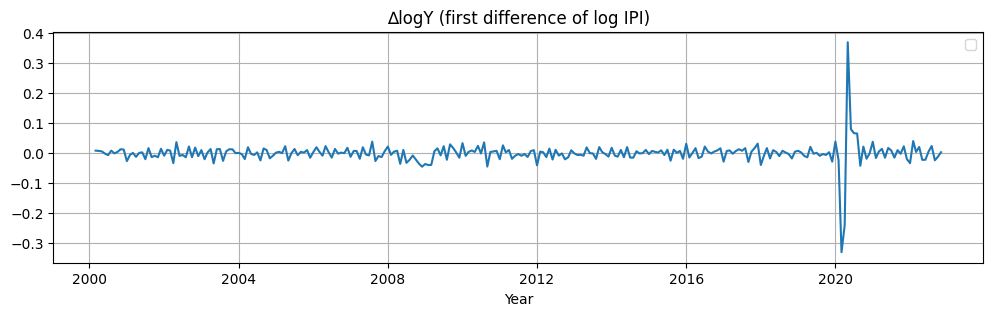

In [15]:
# Visualize initial time series
plt.figure(figsize=(12,3))
plt.plot(df_final.index, df_final['DLOG_Y_IPI'])
plt.title('∆logY (first difference of log IPI)')
plt.xlabel('Year')
plt.legend()
plt.grid(True)
plt.show()

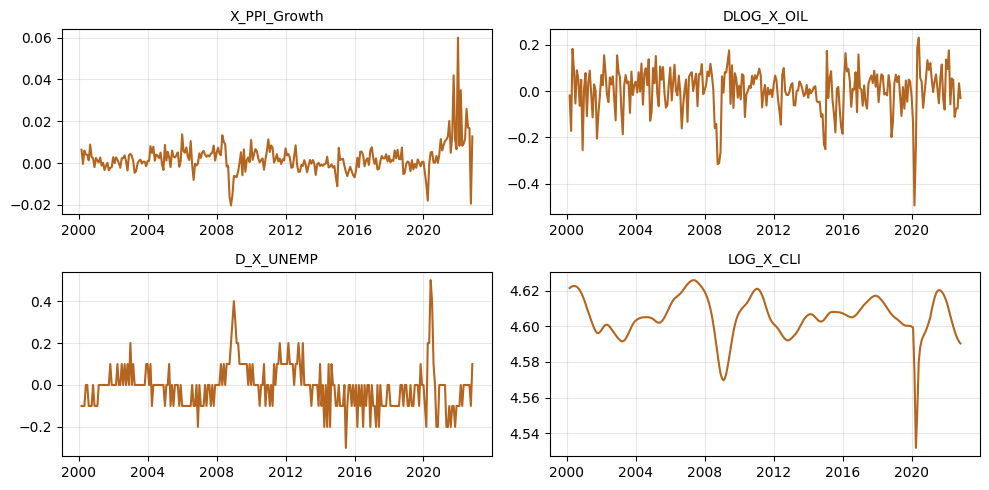

In [16]:
x_columns = [col for col in df_final.columns if col in ["X_PPI_Growth",	"DLOG_X_OIL", "D_X_UNEMP","LOG_X_CLI"]]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 5))
axes = axes.flatten()  # Flatten the 2D grid into a 1D list for easy iteration

# 3. Loop through columns and plot on specific axes
for i, col in enumerate(x_columns):
    # Safety check in case you have fewer/more columns
    if i < len(axes):
        ax = axes[i]
        
        # Plot data
        ax.plot(df_final.index, df_final[col], color="#b4651f", linewidth=1.5)
        
        # Styling
        ax.set_title(col, fontsize=10)
        ax.grid(True, alpha=0.3)
# 4. Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

### Rerun Stationarity check

In [17]:
print("\n" + "=" * 60)
print("Formal ADF Unit Root Tests on Transformed (I(0) Candidate) Series")
print("=" * 60)
for col in df_final.columns:
    run_adf_test(df_final[col], col)
print("=" * 60)


Formal ADF Unit Root Tests on Transformed (I(0) Candidate) Series
--- ADF Test for LOG_Y_IPI ---
ADF Statistic: -2.0742
p-value: 0.2550
Critical Value (5%): -2.8724
Conclusion: Fail to Reject H0. Series is **Non-Stationary (I(1))** (Justifies Differencing).
----------------------------------------
--- ADF Test for DLOG_Y_IPI ---
ADF Statistic: -11.2505
p-value: 0.0000
Critical Value (5%): -2.8723
Conclusion: Reject H0. Series is **Stationary** (Justifies stopping at I(0)).
----------------------------------------
--- ADF Test for X_PPI_Growth ---
ADF Statistic: -3.1005
p-value: 0.0265
Critical Value (5%): -2.8726
Conclusion: Reject H0. Series is **Stationary** (Justifies stopping at I(0)).
----------------------------------------
--- ADF Test for DLOG_X_OIL ---
ADF Statistic: -9.3848
p-value: 0.0000
Critical Value (5%): -2.8723
Conclusion: Reject H0. Series is **Stationary** (Justifies stopping at I(0)).
----------------------------------------
--- ADF Test for D_X_UNEMP ---
ADF Stati

**Now all the series used are stationary**

below the code to save it in a new csv

In [18]:
# output_dir = 'data/processed'
# os.makedirs(output_dir, exist_ok=True)
# output_path = os.path.join(output_dir, 'df_stationary.csv')

# df_final.to_csv(output_path)

# print(f"Data saved successfully to: {output_path}")

# Data Split index and further analysis

In [19]:
N_OBS = len(df_final)
N_TEST = int(N_OBS * 0.20)
TRAIN_END_INDEX = N_OBS - N_TEST

print("--- Data Preparation Summary ---")
print(f"Final Aligned Sample Start: {df_final.index.min().strftime('%Y-%m')}")
print(f"Final Aligned Sample End: {df_final.index.max().strftime('%Y-%m')}")
print("-" * 40)
print("Index for end of training size:", TRAIN_END_INDEX)
print(f"Total Observations (T): {N_OBS}")

--- Data Preparation Summary ---
Final Aligned Sample Start: 2000-03
Final Aligned Sample End: 2022-11
----------------------------------------
Index for end of training size: 219
Total Observations (T): 273


## ACF/PACF visualization

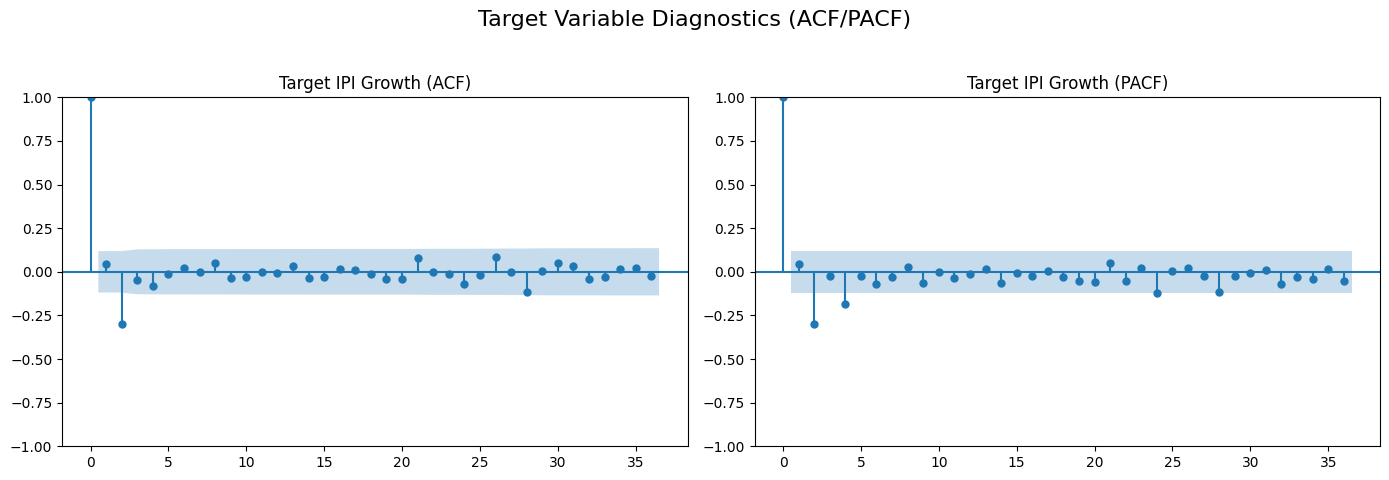

In [20]:
Lags = 36 # 3 years

#  ACF/PACF of the target variable

fig1, axes1 = plt.subplots(1, 2, figsize=(14, 5))
plt.suptitle('Target Variable Diagnostics (ACF/PACF)', fontsize=16)

plot_acf(df_final['DLOG_Y_IPI'], lags=Lags, ax=axes1[0], title='Target IPI Growth (ACF)')
plot_pacf(df_final['DLOG_Y_IPI'], lags=Lags, method='ywm', ax=axes1[1], title='Target IPI Growth (PACF)')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show(fig1)

**For the target variable:** 

1. ACF (Autocorrelation Function) 
- Analysis Observation:  There is a significant negative spike at Lag 2. Following this spike, the correlations drop sharply and largely remain within the blue confidence bands (indicating they are statistically insignificant).
- Theoretical Implication: A sharp "cutoff" in the ACF after a specific lag ($q$) is the signature of a Moving Average (MA) process.
- Conclusion: The ACF suggests an MA component of order $q=1$ or perhaps $q=2$ (if the second lag is considered borderline significant).

2. PACF (Partial Autocorrelation Function) 
- Analysis Observation: There is a significant negative spike at Lag 2, followed by others (tailing off) at 4 especially. S
- Theoretical Implication: When the PACF "tails off" or decays gradually rather than cutting off abruptly, it indicates the presence of a Moving Average (MA) process. (Conversely, if it were an AR process, the PACF would cut off while the ACF tailed off).
- Conclusion: The gradual decay confirms the MA structure suggested by the ACF.

Another important point is that, as expected, no real seasonality is clear here. This is mainly due to the fact that our target variable is already seasonally adjusted when taken from FRED.

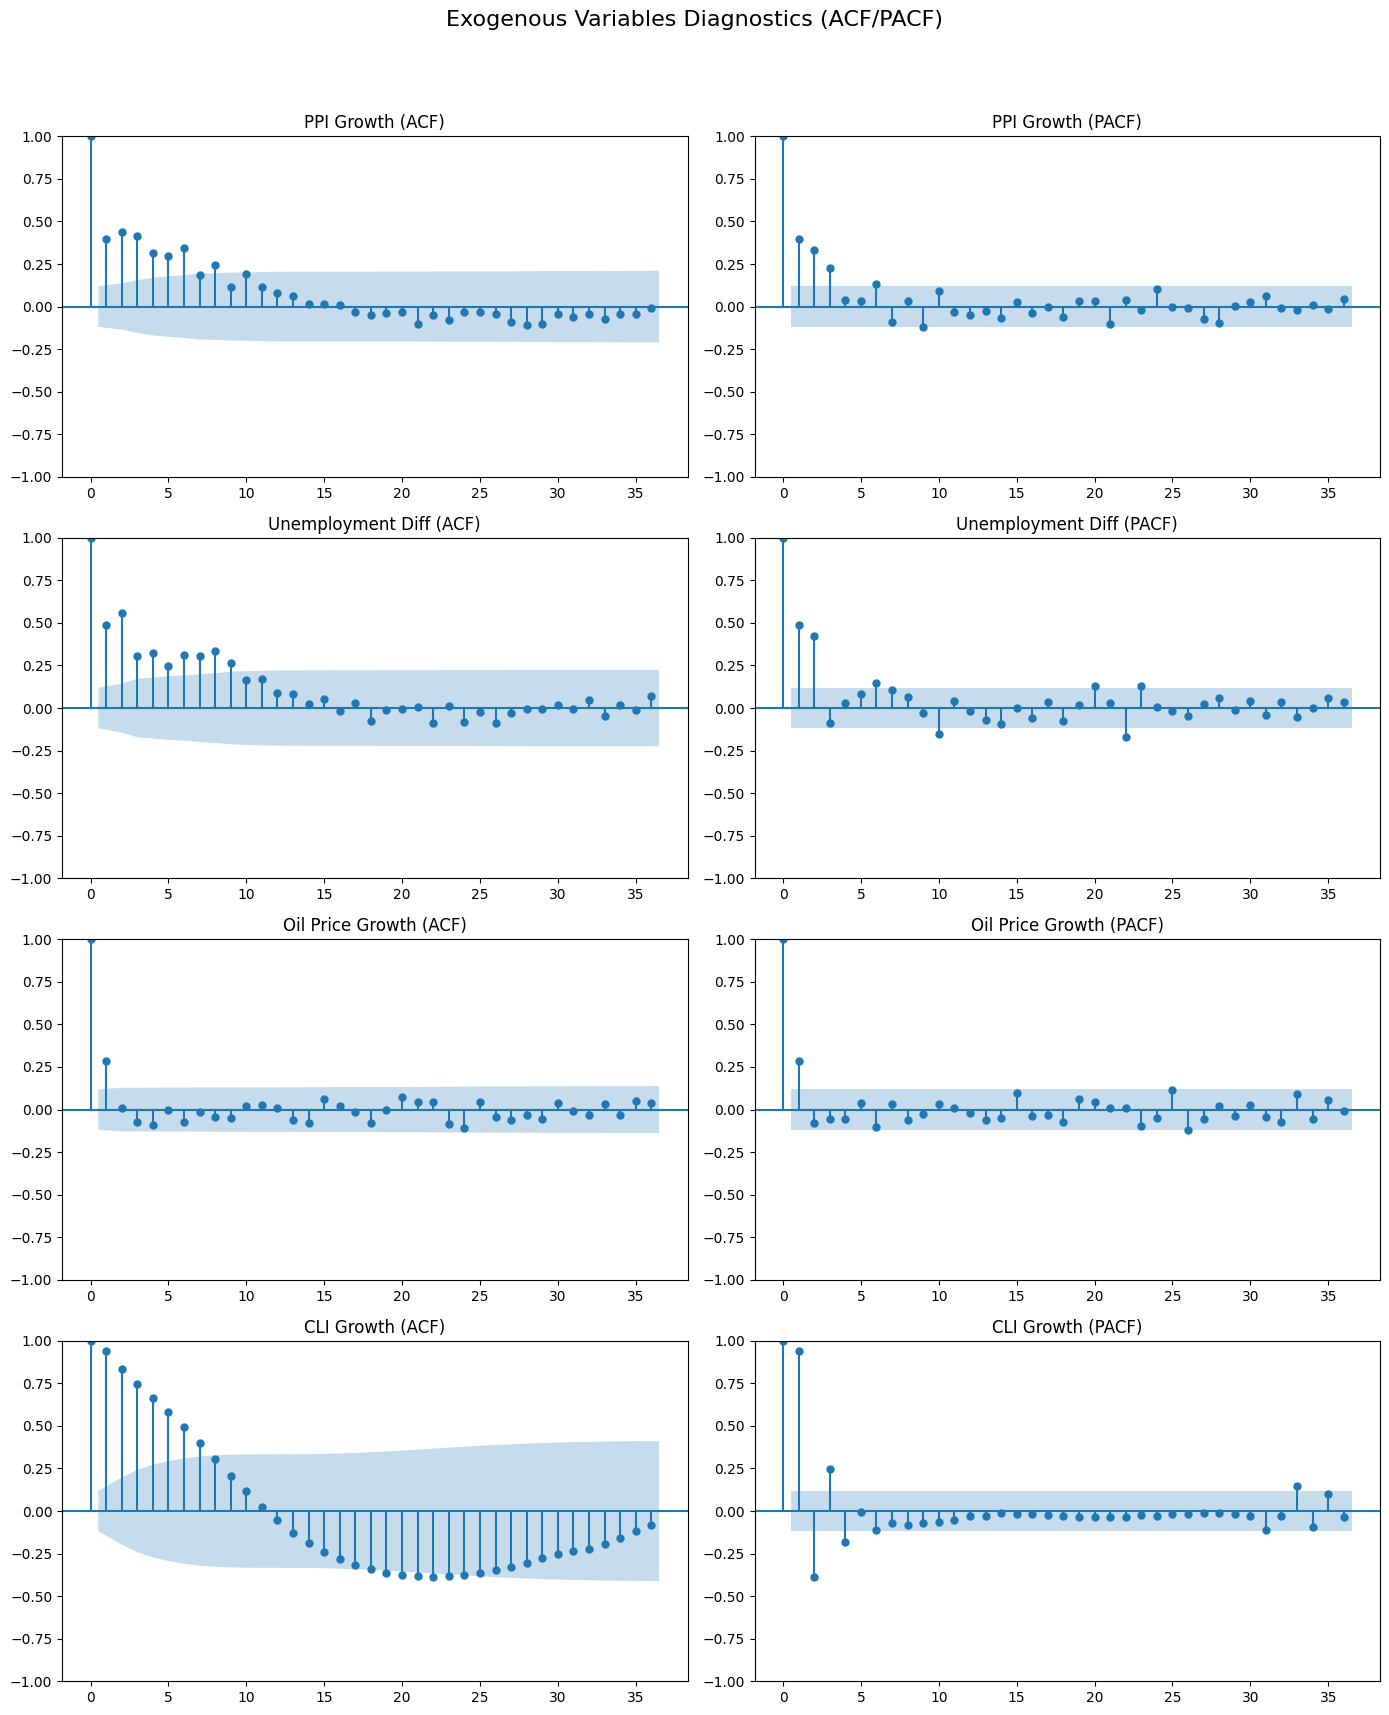

In [21]:
#  ACF/PACF of the exogenous variable

fig2, axes2 = plt.subplots(4, 2, figsize=(14, 18))
plt.suptitle('Exogenous Variables Diagnostics (ACF/PACF)', fontsize=16)

# Row 1: PPI (YoY) - CHECK FOR SEASONALITY
plot_acf(df_final['X_PPI_Growth'], lags=Lags, ax=axes2[0, 0], title='PPI Growth (ACF)')
plot_pacf(df_final['X_PPI_Growth'], lags=Lags, method='ywm', ax=axes2[0, 1], title='PPI Growth (PACF)')

# Row 2: Unemployment (Difference) - CHECK FOR AR/MA STRUCTURE
plot_acf(df_final['D_X_UNEMP'], lags=Lags, ax=axes2[1, 0], title='Unemployment Diff (ACF)')
plot_pacf(df_final['D_X_UNEMP'], lags=Lags, method='ywm', ax=axes2[1, 1], title='Unemployment Diff (PACF)')

# Row 3: Oil Price (Growth) - CHECK FOR AR/MA STRUCTURE
plot_acf(df_final['DLOG_X_OIL'], lags=Lags, ax=axes2[2, 0], title='Oil Price Growth (ACF)')
plot_pacf(df_final['DLOG_X_OIL'], lags=Lags, method='ywm', ax=axes2[2, 1], title='Oil Price Growth (PACF)')

# Row 4: CLI (Growth) - CHECK FOR AR/MA STRUCTURE
plot_acf(df_final['LOG_X_CLI'], lags=Lags, ax=axes2[3, 0], title='CLI Growth (ACF)')
plot_pacf(df_final['LOG_X_CLI'], lags=Lags, method='ywm', ax=axes2[3, 1], title='CLI Growth (PACF)')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show(fig2) #change close to show to visualize the ACF/PACF of exogenous variables

# Benchmark selection

In [22]:
# Split the Log Level data
train_data = df_final['LOG_Y_IPI'].iloc[:TRAIN_END_INDEX]
test_data = df_final['LOG_Y_IPI'].iloc[TRAIN_END_INDEX:]

print(f"Training samples: {len(train_data)}")
print(f"Test samples: {len(test_data)}")

Training samples: 219
Test samples: 54


### AIC/BIC evaluation of benchmarks ARIMA/RW

In [23]:
# Benchmark Selection (AIC/BIC on Training Data Only)

# We specifically test the (0,1,2) they liked, plus others.
# Also excluding constant (trend='n') as discussed.
candidate_orders = [
    (0, 1, 0), # Random Walk
    (1, 1, 0),
    (0, 1, 1),
    (1, 1, 1),
    (2, 1, 0),
    (0, 1, 2), 
]

results = []

print("\n--- Benchmark Selection (AIC/BIC on Training Data) ---")
for order in candidate_orders:
    try:
        # enforce_stationarity=False often helps with convergence
        model = ARIMA(train_data, order=order, trend='n') 
        model_fit = model.fit()
        results.append({
            'Order': order,
            'AIC': model_fit.aic,
            'BIC': model_fit.bic
        })
    except:
        print(f"Failed to fit order {order}")

results_df = pd.DataFrame(results).sort_values(by='AIC')
print(results_df)

# Identify best model order (assuming it's (0,1,2) based on previous turns, but let's be dynamic)
best_order = results_df.iloc[0]['Order']
print(f"\nBest Model by AIC: {best_order}")



--- Benchmark Selection (AIC/BIC on Training Data) ---
       Order          AIC          BIC
5  (0, 1, 2) -1181.788734 -1171.635248
1  (1, 1, 0) -1179.626338 -1172.857348
4  (2, 1, 0) -1178.156479 -1168.002994
2  (0, 1, 1) -1178.030308 -1171.261318
3  (1, 1, 1) -1177.640549 -1167.487063
0  (0, 1, 0) -1172.365517 -1168.981022

Best Model by AIC: (0, 1, 2)


In [24]:
arima_012 = ARIMA(train_data, order=(0,1,2)).fit()
arima_012.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              LOG_Y_IPI   No. Observations:                  219
Model:                 ARIMA(0, 1, 2)   Log Likelihood                 593.894
Date:                Wed, 19 Nov 2025   AIC                          -1181.789
Time:                        19:20:43   BIC                          -1171.635
Sample:                    03-01-2000   HQIC                         -1177.688
                         - 05-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2551      0.056     -4.551      0.000      -0.365      -0.145
ma.L2          0.1682      0.063      2.654      0.008       0.044       0.292
sigma2         0.0003   2.51e-05     10.036      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.20   Jarque-Bera (JB):                 7.81
Prob(Q):                              0.66   Prob(JB):                         0.02
Heteroskedasticity (H):               1.09   Skew:                            -0.45
Prob(H) (two-sided):                  0.72   Kurtosis:                         3.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

So the benchmark model selected according to AIC/BIC for our $y_t$ (Italian IPI) seems to be **ARIMA(0,1,2)**

(looking back at it after forcast evaluation)

The ARIMA(0,1,2) diagnostic checks reveal a mixed result. The Ljung-Box test (p=0.65) indicates the model successfully captured the autocorrelation structure (no signal left behind). However, the Jarque-Bera and Heteroskedasticity tests failed significantly ($p < 0.01$). This confirms that while the model captures the average dynamics, it cannot account for the extreme shocks (Kurtosis = 41.9) and changing volatility inherent in the Italian industrial sector (e.g., Covid-19). This violation of normality assumptions explains why the robust Random Walk outperformed the ARIMA in the out-of-sample test.

### Forecasts evaluation of potential Benchmarks (1-step-ahead forecast)

In [25]:
# Function for rolling forecast
def ARIMA_rolling_forecast(series_full, train_end_idx, order, label):
    history = [x for x in series_full.iloc[:train_end_idx]]
    test_values = series_full.iloc[train_end_idx:]
    preds = []

    # We iterate through the test set
    for i in range(len(test_values)):
        # Fit model on current history
        # To speed up, in a real scenario we might filter, but here we fit.
        # Fitting every step can be slow for long test sets, but N=54 is manageable.
        model = ARIMA(history, order=order, trend='n')
        model_fit = model.fit()
        
        # Forecast next step
        yhat = model_fit.forecast()[0]
        preds.append(yhat)
        
        # Add true observation to history for next iteration
        history.append(test_values.iloc[i])
        
    return pd.Series(preds, index=test_values.index)

# Run for Best AIC Model
preds_best = ARIMA_rolling_forecast(df_final['LOG_Y_IPI'], TRAIN_END_INDEX, best_order, "ARIMA")

# Run for Random Walk (0, 1, 0)
preds_rw = ARIMA_rolling_forecast(df_final['LOG_Y_IPI'], TRAIN_END_INDEX, (0, 1, 0), "Random Walk")

                  RMSE
Random Walk   6.235937
ARIMA(0,1,2)  6.910967
None


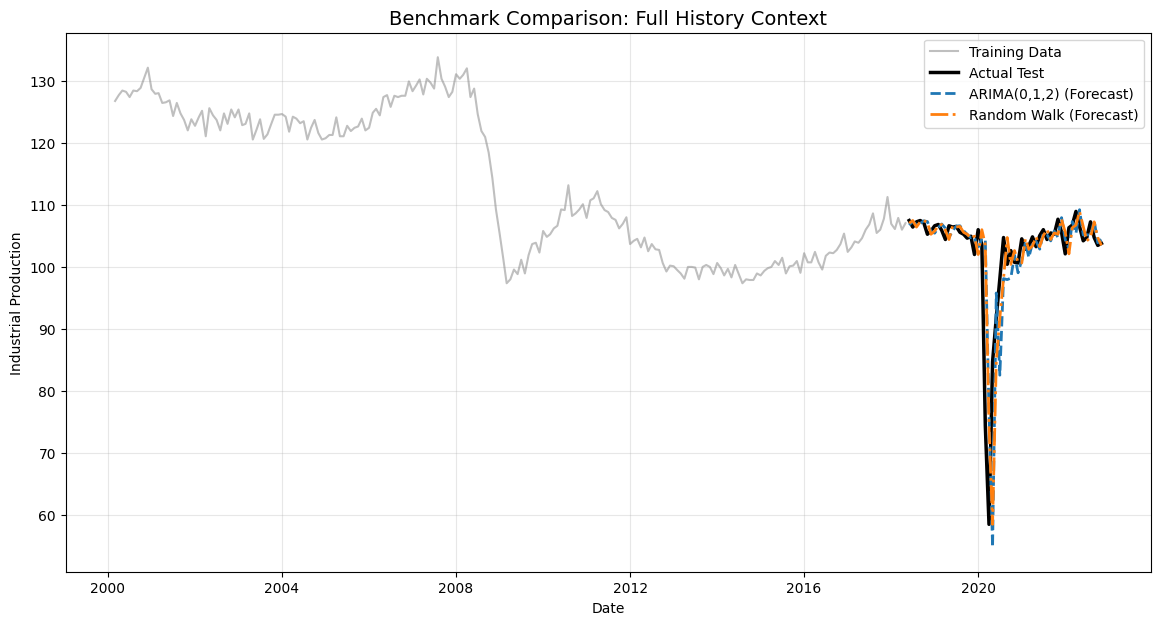

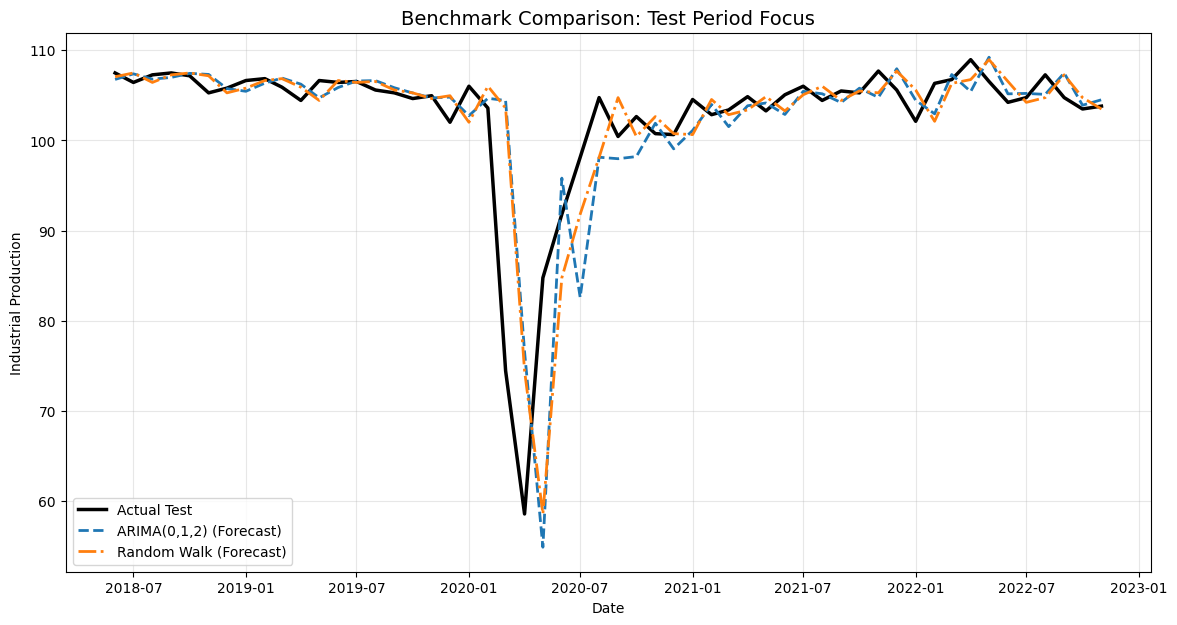

In [26]:
# Convert back to Levels for RMSE
test_level = np.exp(test_data)
preds_best_level = np.exp(preds_best)
preds_rw_level = np.exp(preds_rw)

# 1. Organize your predictions into a dictionary
preds_dict = {
    'ARIMA(0,1,2)': preds_best_level,
    'Random Walk': preds_rw_level
}

# Calculate and Print Metrics
metrics_df = compare_metrics(test_level, preds_dict)
print(metrics_df)

# Plot WITH Training Data (Big Picture)
plot_forecasts(
    test=test_level,
    predictions_dict=preds_dict,
    train=np.exp(train_data), # Revert log for plotting
    title="Benchmark Comparison: Full History Context"
)

# Plot WITHOUT Training Data (Zoomed in on Forecast Accuracy)
plot_forecasts(
    test=test_level,
    predictions_dict=preds_dict,
    train=None, # Set to None to zoom in
    title="Benchmark Comparison: Test Period Focus"
)

### Benchmark Selection Insight

Upon comparing candidate univariate models, we observed a divergence between in-sample and out-of-sample metrics. The ARIMA(0, 1, 2) model yielded the lowest AIC/BIC on the training set (2000–2018), effectively capturing the negative autocorrelation at Lag 2 inherent in the historical data.

However, when evaluated on the test set (2018–2022), the Naive Random Walk outperformed the ARIMA model (RMSE of 6.24 vs. 6.91). This suggests that the specific autoregressive/moving-average dynamics learned from the quiet period (2000–2017) did not hold during the volatile post-2018 period (Covid-19 shock and recovery). The ARIMA model effectively 'overfitted' to historical patterns that were not robust to structural shocks.

**Decision: We select the Random Walk as our Benchmark.**

#### _NOTICE THAT:_

a comparison for a univariate model including all past data was done through coding
the result was that no big improvements arise by using the entire dataset of $Y$ (starting from 1955 c.a.)

So we are gonna keep using the most recent data to which all of our exogenous variables are applicable